In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng

import scipy.io as sio
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge, measure_pce
from best_subset import *
from UBIC import *
from solvel0 import solvel0
from findiff import FinDiff
import sgolay2

Sklearn's version: 1.2.2


#### Load data

In [2]:
# data = sio.loadmat('../../PDE-FIND/Datasets/reaction_diffusion_2d_big.mat')
data = sio.loadmat('../Datasets/reaction_diffusion_2d_big.mat')
u_sol = (data['u']).real
v_sol = (data['v']).real
x = (data['x'][0]).real
y = (data['y'][0]).real
t = (data['t'][:,0]).real

n = 512; issub = 2
if issub > 1:
    spatial_sub_indices = np.array([i for i in range(n) if i%issub==0])
    u_sol = u_sol[spatial_sub_indices, :, :][:, spatial_sub_indices, :]
    v_sol = v_sol[spatial_sub_indices, :, :][:, spatial_sub_indices, :]
    x = x[spatial_sub_indices]
    y = y[spatial_sub_indices]
m = 201; issub = 1
if issub > 1:
    time_sub_indices = np.array([i for i in range(m) if i%issub==0])
    u_sol = u_sol[:, :, time_sub_indices]
    v_sol = v_sol[:, :, time_sub_indices]
    t = t[time_sub_indices]

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

# Ground truth
ground_indices_u = np.array((0, 2, 3, 4, 5, 8, 14))
ground_coeff_u = np.array([1.000,-1.000,1.000,-1.000,1.000,0.100,0.100])
ground_indices_v = np.array((1, 2, 3, 4, 5, 9, 15))
ground_coeff_v = np.array([1.000,-1.000,-1.000,-1.000,-1.000,0.100,0.100])

In [3]:
u = np.zeros((x.shape[0], y.shape[0], len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
np.random.seed(100)
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
XYT = np.transpose([X, Y, T], [1, 2, 3, 0])

#### Add noise

In [4]:
# Need to increase the weak form mesh resolution a bit if data is noisy
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    K=10000,
    is_uniform=True,
    periodic=False,
    include_interaction=True, 
    cache=True
)

u_noisy = u.copy()

### Add noise ###
noise_lv = 10
domain_noise = 0.01*np.abs(noise_lv)*np.std(u_noisy)*np.random.randn(*u_noisy.shape)
u_noisy = u_noisy + domain_noise

#### Denoise

In [5]:
denoise = True
if denoise:
    un = u_noisy[:, :, :, 0].T
    vn = u_noisy[:, :, :, 1].T

    div = 30
    ws = max(un[0].shape)//div; po = 2
    if ws%2 == 0: ws -=1

    und = []
    for i in trange(un.shape[0]):
        und.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(un[i]))
    und = np.stack(und, axis=0).T

    vnd = []
    for i in trange(vn.shape[0]):
        vnd.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(vn[i]))
    vnd = np.stack(vnd, axis=0).T

    u_noisy = np.stack((und, vnd), axis=-1)
    del und, vnd, un, vn

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:01<00:00, 102.61it/s]


#### Applying best-subset regression on the weak formulation

In [6]:
thres = 1e-4 # 1e-3
# optimizer = ps.STLSQ(threshold=thres, fit_intercept=True, normalize_columns=True, max_iter=100)
optimizer = ps.SR3(threshold=thres, fit_intercept=True, normalize_columns=True, max_iter=100)
# optimizer = ps.MIOSR(target_sparsity=2*7, fit_intercept=False, normalize_columns=True)

model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer, 
                 cache=True, feature_names=['u', 'v'])
model.fit(u_noisy, ensemble=False, library_ensemble=True)
# model.print()
X_pre, y_pre = model.feature_library.cached_xp_full[0], model.cached_x_dot

In [7]:
feature_names = np.array(model.get_feature_names())
u_pre, v_pre = y_pre[:, 0:1], y_pre[:, 1:2]
del y_pre

In [8]:
solve_grb = solvel0(X_pre, u_pre, intercept=False, refine=True, max_complexity=10)

potential_indices = Counter(solve_grb[0])
for e in solve_grb[1:]: 
    potential_indices += Counter(e)
potential_indices = sorted(potential_indices, key=potential_indices.get, reverse=True)[:15]
potential_indices = sorted(potential_indices)
potential_feature_names = feature_names[potential_indices]

brute_solve = brute_force_all_subsets(X_pre[:, potential_indices], u_pre, max_support_size=10)
map2pysindy = dict(zip([i for i in range(len(potential_indices))], potential_indices))
best_subsets_u = [tuple([map2pysindy[ei] for ei in effective_indices]) 
                  for effective_indices in brute_solve[-1]]
best_subsets_u

  0%|                                                                                                                              | 0/10 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.96it/s]


Call backward_refinement...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.50it/s]


[(1,),
 (1, 14),
 (0, 1, 14),
 (0, 1, 8, 14),
 (0, 1, 8, 9, 14),
 (0, 1, 2, 4, 8, 14),
 (0, 2, 3, 4, 5, 8, 14),
 (0, 1, 2, 3, 4, 5, 8, 14),
 (0, 1, 2, 3, 4, 5, 8, 14, 39),
 (0, 1, 2, 3, 4, 5, 8, 14, 39, 42)]

#### Model selection by the UBIC (Algorithm 1)

In [9]:
tau = 3; per = 75
scale = np.log(len(u_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets_u, (X_pre, u_pre), u_type='cv1', take_sqrt=True)
print(min(b_bics)-max(b_bics))
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets_u])
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets_u):
    com = len(efi)
    assert com == np.count_nonzero(post_means[:, k:k+1])
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], u_pre)/np.log(len(u_pre))-com # old version without scale
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], u_pre))-np.log(len(u_pre))*com
    lower_bounds.append(lower_bound)
    
last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 10)
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

last_lam = round(last_lam, 10)
last_lam_d_u = last_lam
last_ubic_d_u = last_ubic
last_bc_d_u = last_bc
uns_u = b_uns
last_lam, last_ubic, last_bc

-14962.70186852511
0.028408923577772496
0 <---> 0 inf
0 <---> 6 0.030003039304471672
6 <---> 7 0.0020825485789059523


(1.3165040499,
 array([-81804.19826208, -82158.80397855, -82167.78018353, -83993.6942674 ,
        -83736.88791073, -81586.79224563, -94598.81048007, -91355.37498438,
        -91223.14359055, -91094.15276559]),
 6)

In [10]:
solve_grb = solvel0(X_pre, v_pre, intercept=False, refine=True, max_complexity=10)

potential_indices = Counter(solve_grb[0])
for e in solve_grb[1:]: 
    potential_indices += Counter(e)
potential_indices = sorted(potential_indices, key=potential_indices.get, reverse=True)[:15]
potential_indices = sorted(potential_indices)
potential_feature_names = feature_names[potential_indices]

brute_solve = brute_force_all_subsets(X_pre[:, potential_indices], v_pre, max_support_size=10)
map2pysindy = dict(zip([i for i in range(len(potential_indices))], potential_indices))
best_subsets_v = [tuple([map2pysindy[ei] for ei in effective_indices]) 
                  for effective_indices in brute_solve[-1]]
best_subsets_v

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.28it/s]


Call backward_refinement...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.36it/s]


[(0,),
 (0, 15),
 (0, 1, 15),
 (0, 1, 9, 15),
 (0, 1, 8, 9, 15),
 (0, 1, 3, 5, 9, 15),
 (1, 2, 3, 4, 5, 9, 15),
 (0, 1, 2, 3, 4, 5, 9, 15),
 (0, 1, 2, 3, 4, 5, 9, 15, 64),
 (0, 1, 2, 3, 4, 5, 9, 15, 39, 64)]

In [11]:
tau = 3; per = 75
scale = np.log(len(v_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets_v, (X_pre, v_pre), u_type='cv1', take_sqrt=True)
print(min(b_bics)-max(b_bics))
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets_v])
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets_v):
    com = len(efi)
    assert com == np.count_nonzero(post_means[:, k:k+1])
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], v_pre)/np.log(len(v_pre))-com # old version without scale
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], v_pre))-np.log(len(v_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 10)
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

last_lam = round(last_lam, 10)
last_lam_d_v = last_lam
last_ubic_d_v = last_ubic
last_bc_d_v = last_bc
uns_v = b_uns
last_lam, last_ubic, last_bc

-15915.512397809725
0.031631936733893584
0 <---> 0 inf
0 <---> 6 0.03242979226035913
6 <---> 6 inf


(0.0,
 array([-81057.31443102, -81634.81591469, -82065.30731763, -84914.07706098,
        -85012.99421079, -87174.03385972, -96742.3344358 , -96730.6083764 ,
        -96723.92957382, -96716.08174329]),
 6)

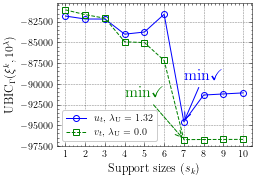

In [12]:
assert list(map(len, best_subsets_u)) == list(map(len, best_subsets_v))
complexities = list(map(len, best_subsets_u))
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot(complexities, last_ubic_d_u, 'o-', c='blue', markerfacecolor='none', label="$u_t,\, \lambda_{\\textrm{U}}=$ "+str(round(last_lam_d_u, 2)))
    ax.plot(complexities, last_ubic_d_v, 's--', c='green', markerfacecolor='none', label="$v_t,\, \lambda_{\\textrm{U}}=$ "+str(round(last_lam_d_v, 2)))
    ax.set_xticks(complexities)
    ax.set_ylabel("$\\textrm{UBIC}_{\\Gamma}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)

    plt.annotate('min$\checkmark$', fontsize=16, c='blue', 
             xy=(complexities[last_bc_d_u], last_ubic_d_u[last_bc_d_u]), 
             xytext=(complexities[last_bc_d_u], last_ubic_d_u[last_bc_d_u]+5000), 
             arrowprops={'arrowstyle': '->', 'linestyle':'-', 'color':'blue'})
    
    plt.annotate('min$\checkmark$', fontsize=16, c='green', 
             xy=(complexities[last_bc_d_v], last_ubic_d_v[last_bc_d_v]), 
             xytext=(complexities[last_bc_d_v]-3, last_ubic_d_v[last_bc_d_v]+5000), 
             arrowprops={'arrowstyle': '->', 'linestyle':'--', 'color':'green'})
    plt.legend()
    plt.show()

#### Percent coefficient error

In [13]:
assert np.alltrue(best_subsets_v[last_bc_d_v] == ground_indices_v) and np.alltrue(best_subsets_u[last_bc_d_u] == ground_indices_u)
errs_u = measure_pce(np.linalg.lstsq(X_pre[:, ground_indices_u], u_pre, rcond=None)[0].flatten(), 
                     ground_coeff_u)
errs_v = measure_pce(np.linalg.lstsq(X_pre[:, ground_indices_v], v_pre, rcond=None)[0].flatten(), 
                     ground_coeff_v)
print(errs_u.mean(), errs_u.std())
print(errs_v.mean(), errs_v.std())

2.163987219452517 1.4818550985128545
2.2967262127979806 1.6589786810247034
